# Fitting

In fitting, we choose a parametric model to describe the data. The model has some parameters that we need to estimate from the data. The goal is to find the best parameters that describe the data.

In [2]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import cv2 as cv
import math

#### Least squares fitting

In least squares fitting, we choose a model that is linear in the parameters. We define a loss function that measures the difference between the model and the data. The loss function is usually the sum of the squared differences between the model and the data. We then find the parameters that minimize the loss function. The parameters can be found by solving the matrix equation:

$$ W = (X^T X)^{-1} X^T Y $$

where $W$ is the vector of parameters, $X$ is the matrix of data, and $Y$ is the vector of target values.

Since $Y = WX$, it might occur that we can obtain $W$ as $W = YX^{-1}$ but this is not the case because $X$ may not a square matrix and hence, we won't be able to find the inverse. To solve this issue, we multiply both sides by $X^T$ to get the following:
$$ X^T Y = X^T X W $$
$$ W = (X^T X)^{-1} X^T Y $$

This doesn't require gradient descent as a closed form solution exists. However, this method is not always the best choice as it may not be the most accurate or efficient method for the problem at hand.

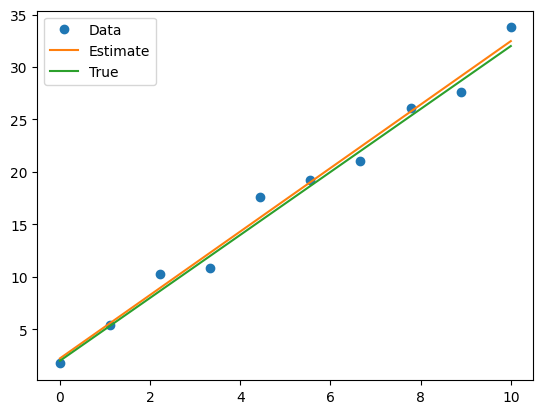

In [2]:
m,b = 3,2
n = 10
x = np.linspace(0,10,n)
y = m*x + b + np.random.normal(0,1,n)

X = np.vstack([x,np.ones(n)]).T  # For the bias term we stack 1
B = np.linalg.inv(X.T @ X) @ X.T @ y # Find the least squares solution using the equation

m_est = B[0]
b_est = B[1]

plt.plot(x,y,'o')
plt.plot(x,m_est*x + b_est)
plt.plot(x,m*x + b)
plt.legend(['Data','Estimate','True'])
plt.show()

### Effect of outliers

In the below code, we see that  the least squares fitting is sensitive to outliers. The model is a line that we fit to the data. The line is pulled towards the outlier and does not represent the data well.

Gradient = 2.9095360245282262, 
Intercept = -3.6906854369045323


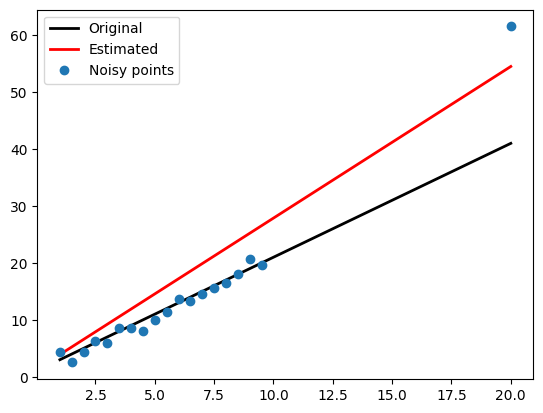

In [3]:
m = 2
c = 1
x = np.arange(1,10, 0.5) # Un-corrupted x
# Append a number to x
x = np.append(x, 20)
n = np.random.randn(len(x))
o = np.zeros(x.shape)
o[-1] = 20 # Outliers
y = m*x + c + n + o

X = np.concatenate([x.reshape(len(x),1), np.ones((len(x), 1))], axis=1) # Add a column of ones for the bias term
B = np.linalg.pinv(X.T@X)@X.T@y # Here the pseudo-inverse is used for cases where the matrix is not invertible
mstar = B[0]
cstar = B[1]
print(f"Gradient = {mstar}, \nIntercept = {cstar}")

plt.plot([x[0], x[-1]], [m*x[0] + c, m*x[-1]+c], color='k', linestyle='-', linewidth=2, label=r'Original')
plt.plot([x[0], x[-1]], [mstar*x[0] + c, mstar*x[-1]+cstar], 
         color='r', linestyle='-', linewidth=2, label=r'Estimated')
plt.plot(x,y, 'o', label='Noisy points')
plt.legend(loc='best')
plt.show()

Slope-intercept parametrization fails for vertical lines as the gradient is 0

Solution is not equivariant w.r.t. rotation:  solution or method is said to be equivariant under rotation if applying a rotation to the data and then performing the operation gives the same result as performing the operation first and then applying the rotation. In the context of least squares regression, this would mean that if you rotate your data points, the regression line should rotate in the same way. When the data is rotated, the vertical distances change, but the least squares regression method does not inherently account for this change in orientation. As a result, the regression line found after rotation may not correspond to the line that would be found by rotating the original regression line, indicating a lack of rotational equivariance. The reason for this is that the least squares regression method is based on minimizing the sum of the squared vertical distances between the data points and the regression line.

### Total Least Squares

We can use total least squares fitting to fit a line to the data. This method minimizes the perpendicular distance from the data points to the line.

We overparameterize the line by adding a third parameter, , which is the distance from the origin to the line along the normal.

d is the mean of the perpendicular distances from the data points to the line.

The distance from a line $ax + by = d$ is given by the formula:

$$d = \frac{1}{\sqrt{a^2 + b^2}} \sum_{i=1}^{n} |a x_i + b y_i - d|$$

Here a and b determine the orientation of the line and d determines the distance to the line from the origin.

Therefore, the objective function to minimize is given by:

$$\sum_{i=1}^{n} (a x_i + b y_i - d)^2$$ 
assuming that $a^2 + b^2 = 1$.

Differentiating the objective function with respect to d gives:

$$\frac{\partial E}{\partial d}  = -2\sum_{i=1}^{n} (a x_i + b y_i - d) = 0$$

Therefore, d is given by:

$$d = \frac{1}{n} \sum_{i=1}^{n} (a x_i + b y_i)$$

Substituting this back into the objective function gives:

$$\sum_{i=1}^{n} (a(x_i -\overline{x}) + b(y_i-\overline{y}))^2$$

$$\lVert\begin{bmatrix}
x_1 - \bar{x} & y_1 - \bar{y} \\
\vdots & \vdots \\
x_n - \bar{x} & y_n - \bar{y}
\end{bmatrix}
\begin{bmatrix}a \\ b \end{bmatrix}\rVert^2$$

We need to find $N$ such that $\|UN\|^2$ is minimized and $a^2 + b^2 = 1$.

The solution to this is given by the right singular vector corresponding to the smallest singular value of the matrix $U$. which is equal to the eigenvector corresponding to the smallest eigenvalue of the matrix $U^TU$.

$U^TU$ is the second moment matrix of the data points given by:

$$\begin{bmatrix}
\sum_{i=1}^{n} (x_i - \bar{x})^2 & \sum_{i=1}^{n} (x_i - \bar{x})(y_i - \bar{y}) \\
\sum_{i=1}^{n} (x_i - \bar{x})(y_i - \bar{y}) & \sum_{i=1}^{n} (y_i - \bar{y})^2
\end{bmatrix}$$

In [4]:
A = np.array([x - np.mean(x),y - np.mean(y)]).T
U,S,V = np.linalg.svd(A.T@A)
print(f"a = {V[0,1]} and b = {V[1,1]}")

a = -0.9504069002111686 and b = 0.3110092024860326


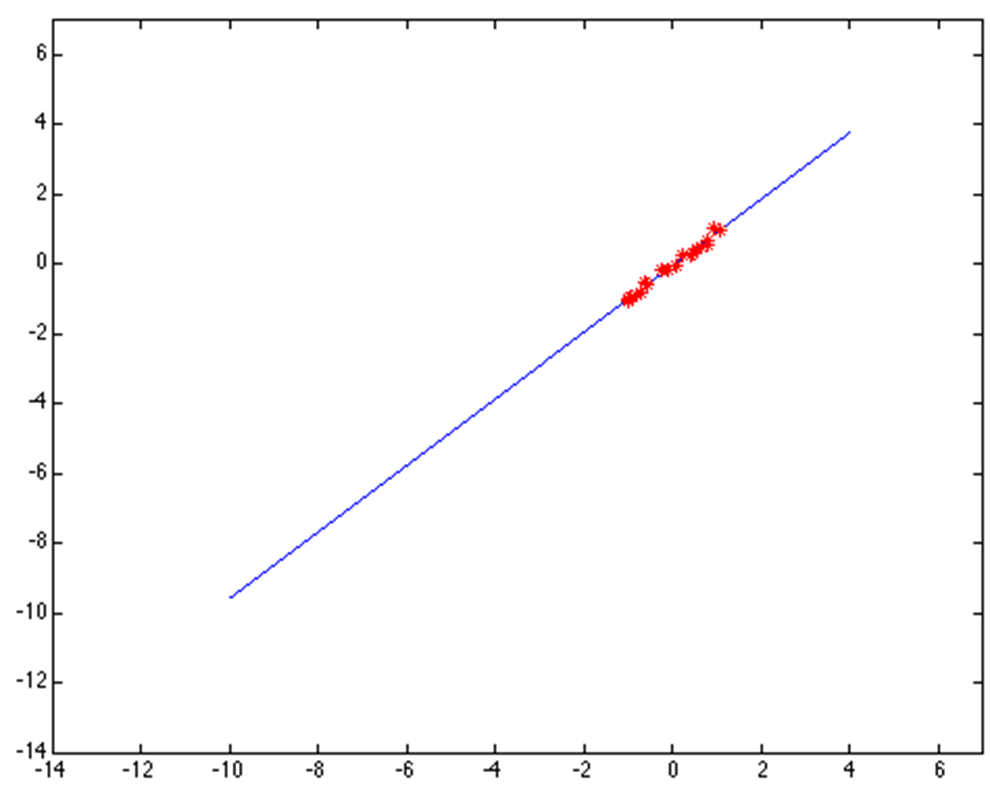

Least squares regression is robust to noise as shown above

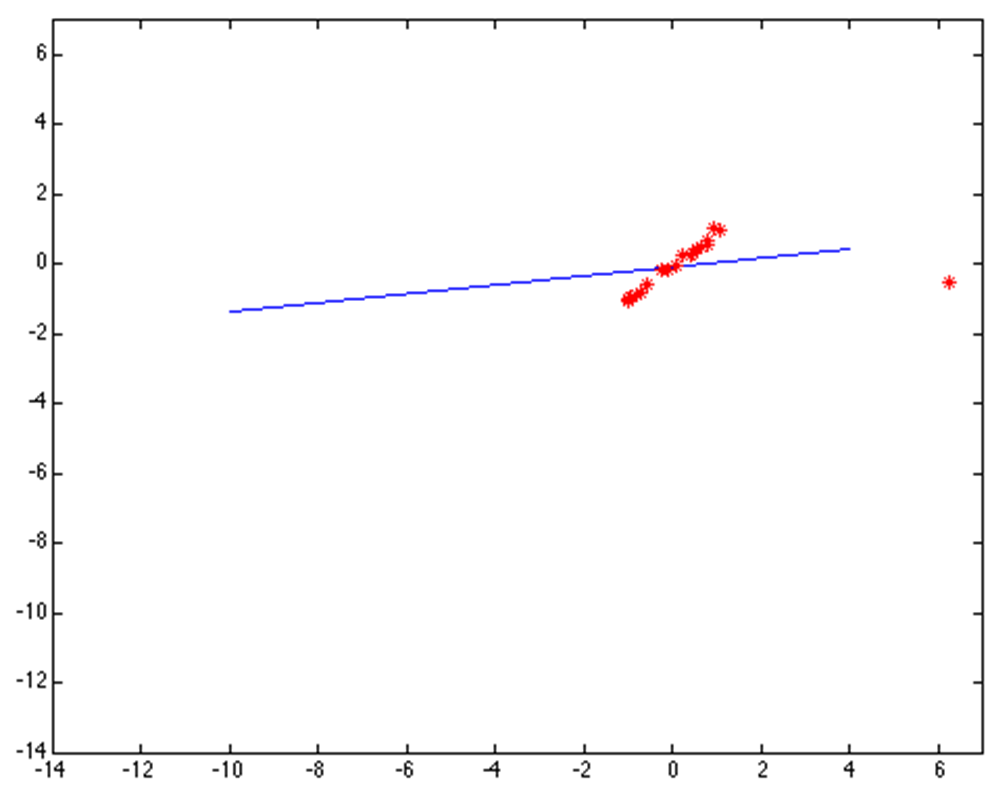

However, an outlier causes the method to fail. This is due to the squaring of the errror as since the error is squared, the outlier has a large effect on the loss function. This is why the line is pulled towards the outlier.

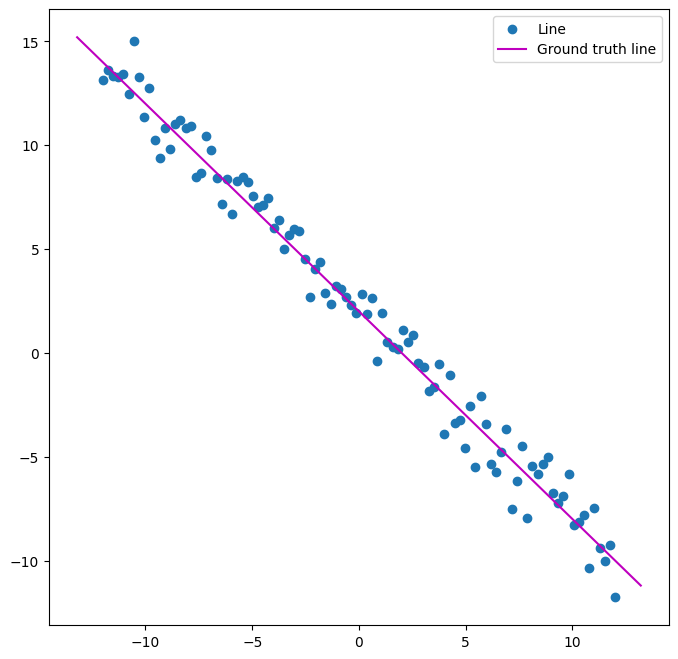

In [5]:
N = 100
t = np.random.uniform(0, 2*np.pi, N)

s = 1.
m, c = -1, 2
x = np.linspace(-12, 12, N) 
y = m*x + c + s*np.random.randn(N)
X_line = np.hstack((x.reshape(N,1), y.reshape(N,1))) 

fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.scatter(X_line[:,0],X_line[:,1], label='Line')
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m*x_ + c
plt.plot(x_, y_, color='m', label='Ground truth line')
plt.legend()
plt.show()

Best line model [0.711195   0.70299478 1.46257594]


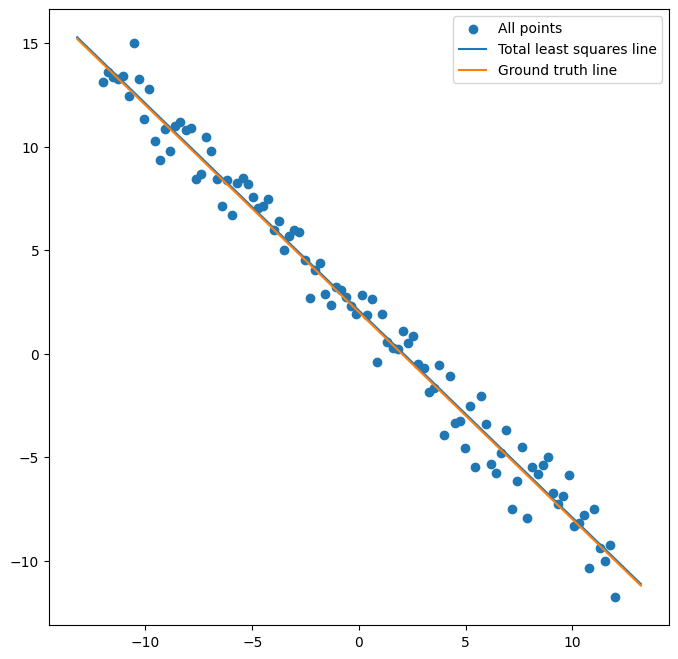

In [7]:
N = X_line.shape[0]
X_ = X_line
U = X_ - np.mean(X_, axis=0)

# Eigenvector of 𝑈^𝑇𝑈 associated with the smallest eigenvalue
_, _, Vt = np.linalg.svd(np.transpose(U)@U)
a, b = Vt[-1, 0], Vt[-1, 1]
d = a*np.mean(X_[:,0]) + b*np.mean(X_[:,1])
best_model_line = np.array([a, b, d])

print('Best line model', best_model_line)

fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.scatter(X_line[:,0],X_line[:,1], label='All points')
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = (-best_model_line[1]*x_ + best_model_line[2])/best_model_line[1]
plt.plot(x_, y_, label='Total least squares line')
y_ = m*x_ + c
plt.plot(x_, y_, label='Ground truth line')
plt.legend()
plt.show()

### Robust Estimators

Robust estimators are statistical methods designed to provide reliable parameter estimates even when the data contains outliers or deviates from assumptions such as normality. Unlike traditional estimators, which can be highly sensitive to outliers, robust estimators aim to minimize the influence of such anomalies, thereby providing more accurate and stable results in the presence of noisy or contaminated data.

The main goal of such an estimator is to minimize 

$$\sum_{i}^{}\rho_\sigma(r(x_i;\theta))$$

where $r(x_i;\theta)$ is the residual with respect to model parameters and $\rho_\sigma$ is a robust function with scale parameter.

Scale refers to a measure of the spread or variability of the data that is resistant to the influence of outliers. If it is too low, the estimator will underfit, while if it is too high, the estimator will be too sensitive to outliers. The scale parameter is used to adjust the sensitivity of the estimator to outliers, with smaller values making the estimator more robust to outliers.

For example, conside the robust function:
$$\rho_{\sigma}(u) = \frac{u^2}{\sigma^2 + u^2}$$

Here, as $u$ increases, the function approaches $1$. This means that the function is less sensitive to outliers as $u$ increases. The scale parameter $\sigma$ determines how quickly the function approaches $1$ as $u$ increases. A larger value of $\sigma$ makes the function less sensitive to outliers.

For the above function, if $\sigma$ is too small, error is almost same for all data points. If it is too large, it behaves like linear regression.

### RANSAC

RANSAC stands for Random Sample Consensus. It is an iterative method to estimate parameters of a mathematical model from a set of observed data that contains outliers. It is a non-deterministic algorithm in the sense that it produces a reasonable result only with a certain probability, with this probability increasing as the number of iterations increases. The previous methods work when outliers are few. What if we have many outliers? RANSAC is a method to deal with this.

Basic idea: All data points vote for all models. The model with the most votes is the best model.

#### Outline 

1. Randomly choose a small subset of points

2. Fit a model to that subset

3. Find all inlier points that are close to the model and reject the rest

4. Repeat and choose the best model. The best model is the one with the most inliers.

#### Parameters

* Number of points to fit the model: $s$ 

* Number of iterations: $N$

* Threshold distance: $\epsilon$

$N$ is chosen such that the probability of there being atleast $1$ good model is $p$.

Assuming an outlier ratio of $e$:

Probability of $s$ points being all inliers: 
$$(1-e)^s$$
Probability of atleast $1$ outlier:

$$1 - (1 - e)^s$$

Probability of all $N$ models being bad:

$$(1 - (1 - e)^s)^N$$

Therefore, probability that all are bad models:

$$1 - p = (1 - (1 - e)^s)^N$$

Therefore $N$ is given by:

$$N = \frac{\log(1-p)}{\log(1 - (1 - e)^s)}$$

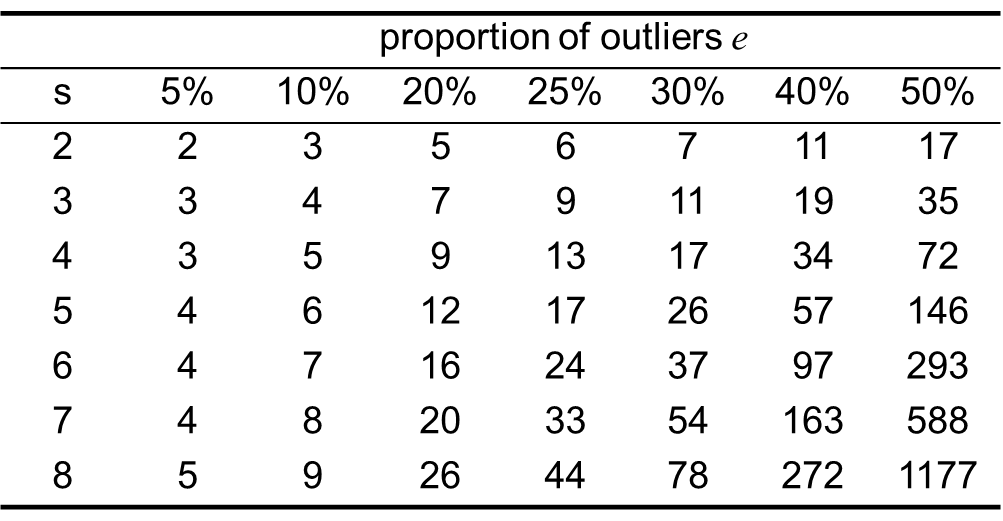

We see in the above table that, when the outliers are high, more iterations are needed. Additionally, when $s$ is high, more iterations are needed.

RANSAC is simple and general and versatile and usually works well in practice. However, there are many parameters to tune and it is computationally expensive. Additionally, if outlier ratio is high, it may not work well.


Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.1125492207534324
            Iterations: 7
            Function evaluations: 32
            Gradient evaluations: 7
rex.x:  [0.71521213 0.69890744 1.6874036 ]
Iteration =  0 . No. inliners =  82
Optimization terminated successfully    (Exit mode 0)
            Current function value: 16.561126495309686
            Iterations: 5
            Function evaluations: 26
            Gradient evaluations: 5
[0.70908679 0.70512121 1.61780595] 16.561126495309686
A better model found ...  [0.70908679 0.70512121 1.61780595] 16.561126495309686
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.7340358373153495
            Iterations: 7
            Function evaluations: 32
            Gradient evaluations: 7
rex.x:  [0.68550705 0.72806599 1.47316539]
Iteration =  1 . No. inliners =  84
Optimization terminated successfully    (Exit mode 0)
            Current function v

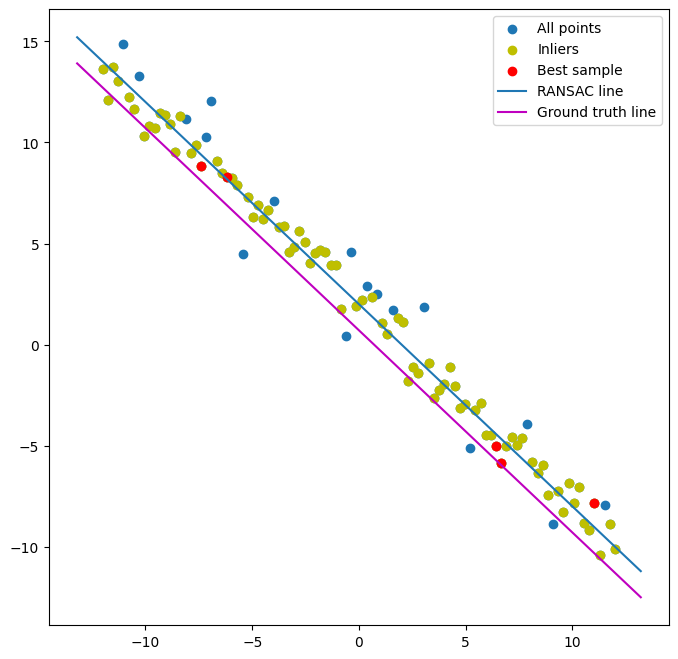

In [8]:
# Item 2: Total least squares line fitting with scicpy.optimize with RANSAC
N = X_line.shape[0]
X_ = X_line

def line_equation_from_points(x1, y1, x2, y2):
    # Calculate the direction vector (Δx, Δy)
    delta_x = x2 - x1
    delta_y = y2 - y1

    # Calculate the normalized vector (a, b)
    magnitude = math.sqrt(delta_x**2 + delta_y**2)
    a = delta_y / magnitude
    b = -delta_x / magnitude

    # Calculate d
    d = (a * x1) + (b * y1)

    # Return the line equation in the form ax + by = d
    return a, b, d

# RANSAC to fit a line
def line_tls(x, indices):
    a, b, d = x[0], x[1], x[2]
    return np.sum(np.square(a*X_[indices,0] + b*X_[indices,1] - d))

# Constraint
def g(x):
    return x[0]**2 + x[1]**2 - 1

cons = ({'type': 'eq', 'fun': g})

# Computing the consensus (inliers)
def consensus_line(X, x, t):
    a, b, d = x[0], x[1], x[2]
    error = np.absolute(a*X_[:,0] + b*X_[:,1] - d)
    return error < t

t = 1.   # Threshold value to determine data points that are fit well by model.
d = 0.4*N   # Number of close data points required to assert that a model fits well to data.
s = 5       # Minimum number of data points required to estimate model parameters.

inliers_line = []        # Indinces of the inliers
max_iterations = 50
iteration = 0
best_model_line = []     # Best model normal (a, b) and distance from origin d
best_error = np.inf
best_sample_line = []    # Three-point sample leading to the best model computation
res_only_with_sample = [] # Result (a, b, d) only using the best sample
best_inliers_line = []   # Inliers of the model computed form the best sample

while iteration < max_iterations:   
    indices = np.random.randint(0, N, s) # A sample of three (s) points selected at random
    x0 = np.array([1, 1, 0]) # Initial estimate
    res = minimize(fun = line_tls, args = indices, x0 = x0, tol= 1e-6, constraints=cons, options={'disp': True})
    inliers_line = consensus_line(X_, res.x, t) # Computing the inliers
    print('rex.x: ', res.x)    
    print('Iteration = ', iteration, '. No. inliners = ', inliers_line.sum())
    if inliers_line.sum() > d:
        x0 = res.x
        # Computing the new model using the inliers
        res = minimize(fun = line_tls, args = inliers_line, x0 = x0, tol= 1e-6, constraints=cons, options={'disp': True})
        print(res.x, res.fun)
        if res.fun < best_error:
            print('A better model found ... ', res.x, res.fun)
            best_model_line = res.x
            best_eror = res.fun
            best_sample_line = X_[indices,:]
            res_only_with_sample = x0
            best_inliers_line = inliers_line

    iteration += 1

print('Best line model', best_model_line)

fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.scatter(X_line[:,0],X_line[:,1], label='All points')
ax.scatter(X_[best_inliers_line,0],X_[best_inliers_line,1], color='y', label='Inliers')
ax.scatter(best_sample_line[:,0],best_sample_line[:,1], color='r', label='Best sample')
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = (-best_model_line[1]*x_ + best_model_line[2])/best_model_line[1]
plt.plot(x_, y_,  label='RANSAC line')
x_ = np.array([x_min, x_max])
y_ = m*x_ + b
plt.plot(x_, y_, color='m', label='Ground truth line')
plt.legend()

Samples [69 37]
[7.9 4.7] [12.7432823   7.34202397]
m, b: 1.687893228629302 -0.5910742051549551
[6.52006055e+00 3.45811722e+00 4.90506682e+01 1.26513402e+01
 7.35624968e+01 8.22387187e+01 2.00064647e+01 6.46937335e+00
 6.91772344e+00 8.44585473e+01 4.70481079e+01 1.07990189e+00
 8.05461287e-02 4.99325633e-04 4.01486400e+00 2.51639592e+01
 9.60014469e+01 3.39693889e+00 4.81058877e+00 5.11387405e-01
 6.57647706e-01 5.58185563e+01 2.42418193e+00 6.92495652e-01
 9.14846529e+01 1.50884801e+01 5.10879728e+01 1.77336476e+01
 1.74128089e+01 2.12592722e+02 5.26097718e+01 8.81794488e-02
 3.44405251e+00 1.09876200e+01 6.93918757e+00 3.79307101e+00
 1.07599394e+02 1.39747486e+00 2.11559641e+01 6.86580082e+01
 2.18653699e+01 3.64969832e+00 7.54327179e+01 3.47537773e-01
 1.66645214e+00 1.31756041e+01 2.03227953e+01 4.25248266e+01
 2.42705267e-01 3.05551804e+01 8.21283266e+01 1.88667779e+01
 8.36684376e+01 1.06509395e+02 5.41259533e+00 5.63129867e-03
 2.76733902e+01 1.34254576e+02 2.53826432e+00 1.88

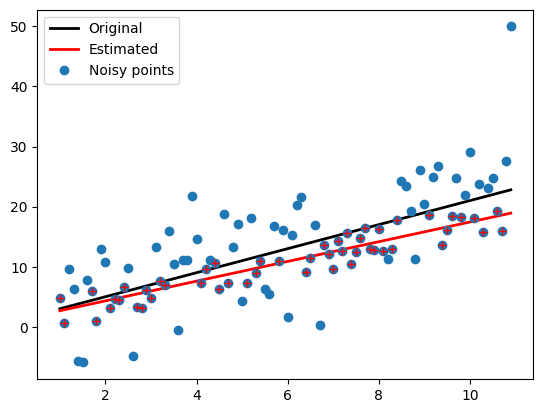

In [9]:
m = 2
c = 1
xo = np.arange(1,11, 0.1) # Un-corrupted x
mu, sigma = 0, 5 # mean and standard deviation
#x = xo + np.random.normal(mu, sigma, len(xo)) # noisy x
x = xo
n = np.random.normal(mu, sigma, len(xo))
o = np.zeros(x.shape)
o[-1] = 20 # Outliers
y = m*x + c + n + o

def line(x,y):
    m = (y[1] - y[0])/(x[1] - x[0])
    b = y[0] - m*x[0]
    print("m, b:", m, b)
    return m, -1, b

def distance(parameters, x, y):
    a = parameters[0]
    b = parameters[1]
    d = parameters[2]
    return (a*x + b*y - d)**2


thresh = 10
s = 2
loop = True 
consensus = []
while loop:
    samples = np.random.choice(len(x), 2, replace=False)
    print("Samples", samples)
    xs = x[samples]
    ys = y[samples]
    print(xs,ys)
    parameters = line(xs,ys)
    print(distance(parameters, x, y) )
    consensus =  distance(parameters, x, y) < thresh
    print('Consensus: ', consensus)
    print("Lenght:", sum(consensus))
    if sum(consensus) >= 2:
        loop = False
    

xc = x[consensus]
yc = y[consensus]
print("xc:", xc)
print("yc", yc)
X = np.concatenate([xc.reshape(len(xc),1), np.ones((len(xc), 1))], axis=1)
print(X.transpose()@X)
B = np.linalg.pinv(X.T@X)@X.T@yc
print(B)
mstar = B[0]
cstar = B[1]

plt.plot([x[0], x[-1]], [m*x[0] + c, m*x[-1]+c], color='k', linestyle='-', linewidth=2, label=r'Original')
plt.plot([x[0], x[-1]], [mstar*x[0] + c, mstar*x[-1]+cstar], 
         color='r', linestyle='-', linewidth=2, label=r'Estimated')
plt.plot(x,y, 'o', label='Noisy points')
plt.plot(xc, yc, '+', color='r')
plt.legend(loc='best')

### Hough Transform

One of the earliest voting schemes.

#### Outline

1. Discretize the parameter space

2. For each feature point in the image, put a vote in every bin in the parameter space that could have generated this point

3. Find bins that have the most votes.

A line in the image scpace corresponds to a point in the parameter space.

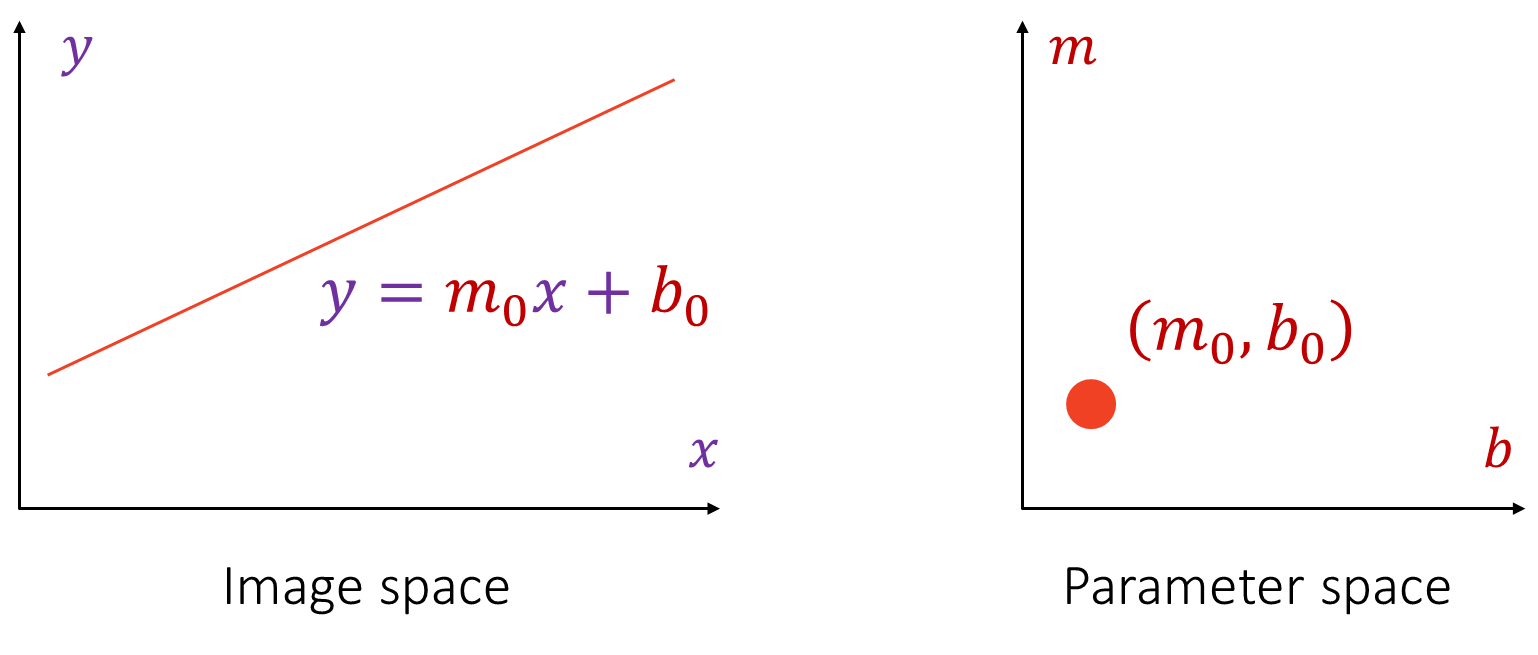

Conversely a point in the image space corresponds to a line in the parameter space.

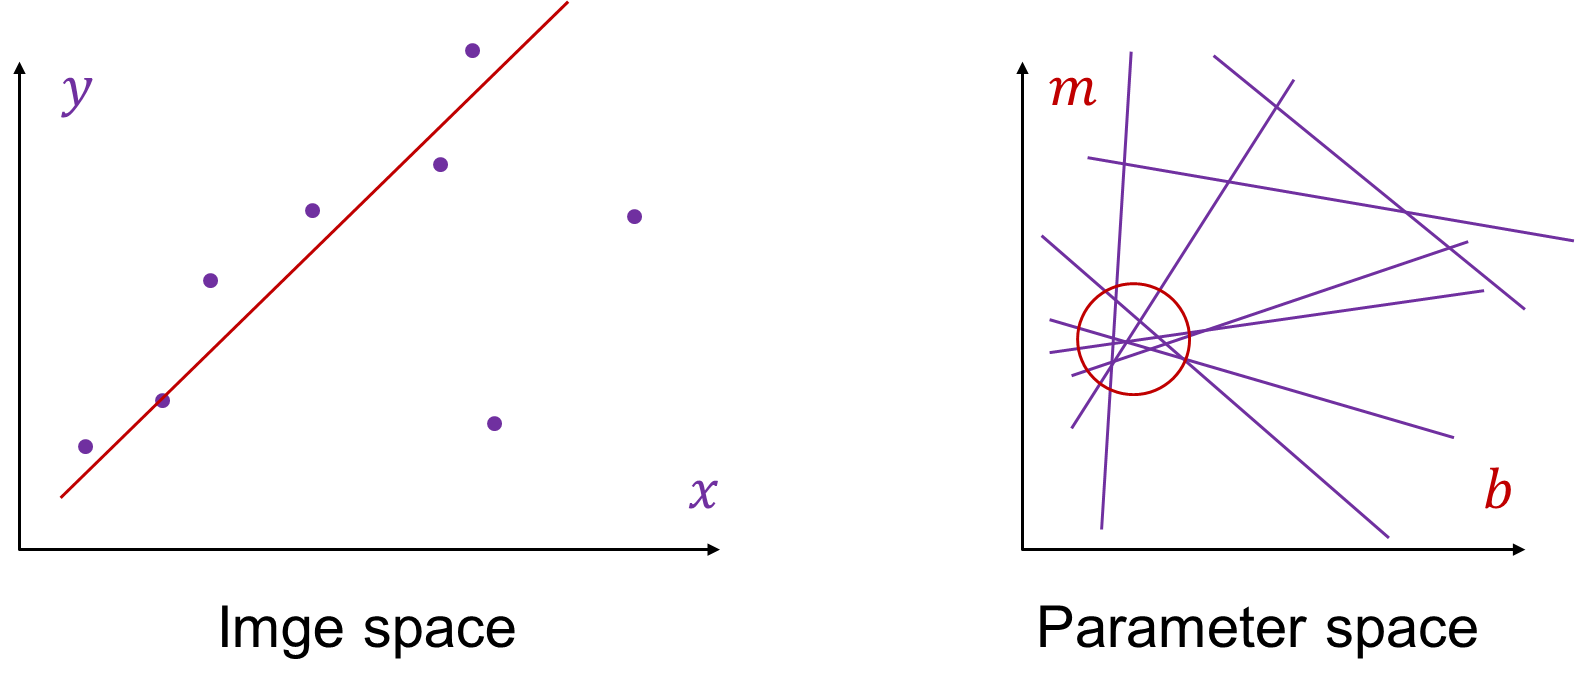

However, in reality, we don't use x, y coordinated as they are unbounded. Instead, we use polar coordinates.

$$\rho = x \cos(\theta) + y \sin(\theta)$$

$\theta$ is finite as it is bounded by $[0, \pi]$. $\rho$ is finite as it cannot be larger than the diagonal of the image.

In this case, a line in the image space corresponds to a sinusoid in the parameter space. The intersection of the sinusoids gives the parameters of the line.

#### Algorithm outline

Initialize accumulator $H$ to all zeros

For each edge point $(x, y)$ in the image space:

For each $\theta$ in the parameter space:

$\rho = x \cos(\theta) + y \sin(\theta)$

Increment $H(\theta, \rho)$

Find the maximum in $H$

How to choose a good discretization?

Too fine: many bins with few votes

Too coarse: votes are spread out

Hough Transforms can deal with non-locailty and occlusion. Can detect multiple instances of a model, somewhat robust to noise and outliers. However, it is computationally expensive and sensitive to discretization and non target shapes can produce peaks in parameter space.

Voting for a patch can help with dealing with noise.

### Hough Lines

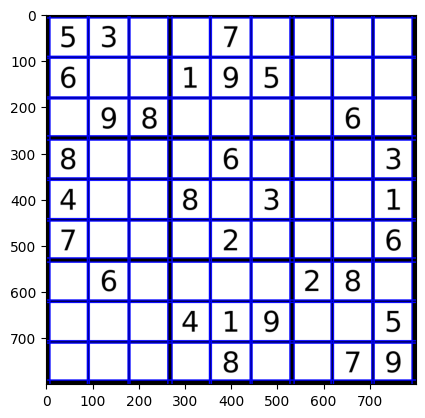

In [4]:
img = cv.imread('images/sudoku.png')
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
edges = cv.Canny(gray,50,100,apertureSize = 3)
lines = cv.HoughLines(edges,1,np.pi/180,200)

# Plotting
for line in lines:
    rho,theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))
    cv.line(img,(x1,y1),(x2,y2),(0,0,255),2)

    
plt.imshow(img)
plt.show()

### Hough Circles

Equation of a circle:

$$(x - a)^2 + (y - b)^2 = r^2$$

The 3 parameters needed are a, b and r.

Assuming the radius is known, the centre of the circle can be found by the following image:

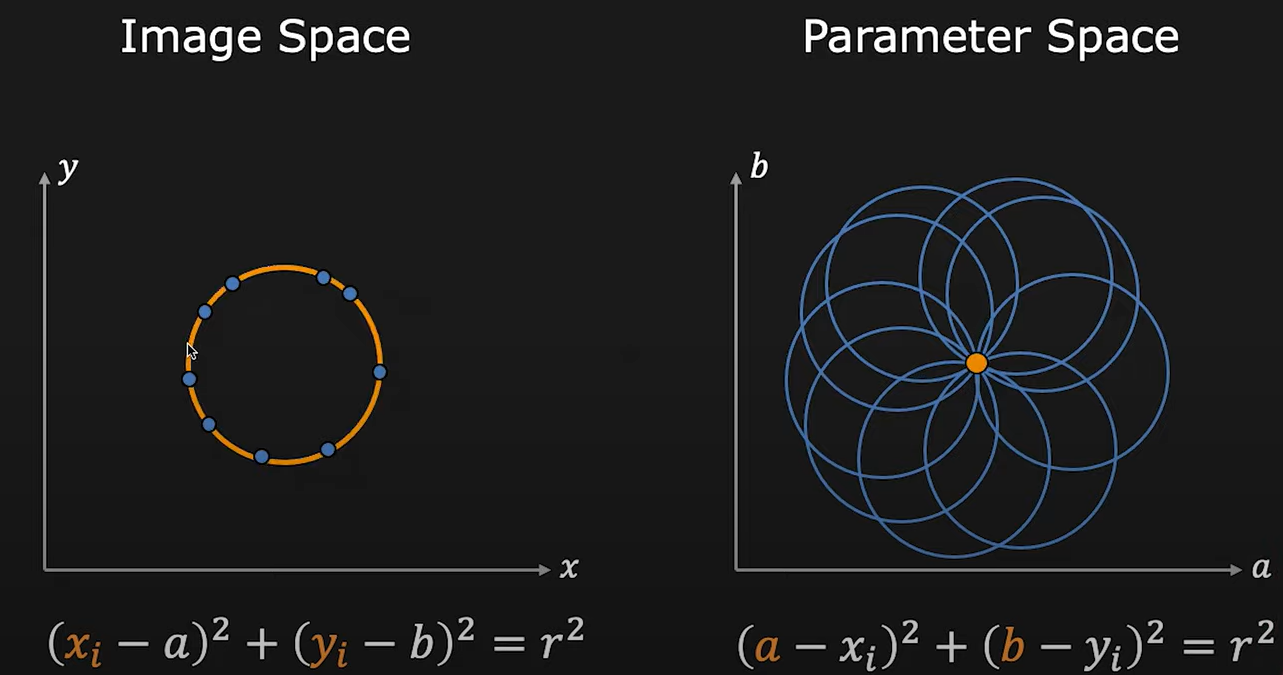

If radius is not known, we get a three dimensional accumulator space. Each point gives the equation of a cone. The intersection of the cones gives the centre and radius of the circle.

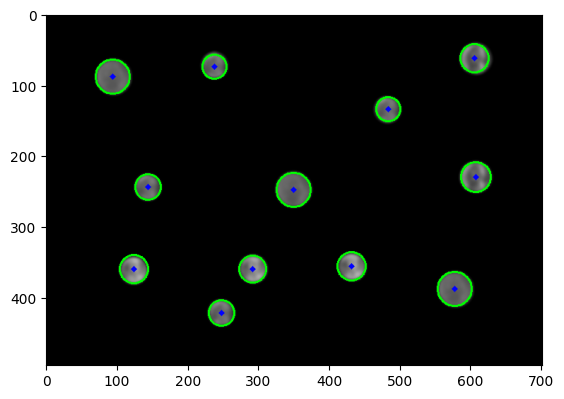

In [6]:
try:
    img = cv.imread('coins/coins.png',0)
    img = cv.resize(img, (0,0), fx=0.2, fy=0.2)
    img = cv.medianBlur(img,7)
    img = cv.GaussianBlur(img, (7,7), 3)
    cimg = cv.cvtColor(img,cv.COLOR_GRAY2BGR)

    circles = cv.HoughCircles(img, cv.HOUGH_GRADIENT,1,40, param1=50,param2=30,minRadius=5,maxRadius=50)

    circles = np.uint16(np.around(circles))
    for i in circles[0,:]:
        # draw the outer circle
        cv.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
        # draw the center of the circle
        cv.circle(cimg,(i[0],i[1]),2,(0,0,255),3)


    plt.imshow(cimg)
    plt.show()
except:
    print("Error loading image")

### Generalized Hough Transform

The generalized Hough Transform is an extension of the Hough Transform that can be used to detect arbitrary shapes in an image. It is based on the principle of template matching, where a template of the object to be detected is created and then matched against the image to find the object.

To do this, first we set a reference point for the object as $(x_c,y_c)$. The accumulator array is then a 2D array with the goal of finding this reference point.

Then for the edge, we find the displacement vector from the referecne. The displacement vector contains the distance and the angle of the edge point from the reference point.

To find the object, we find the reference as the sum of the displacement vector from that point. The reference point is the point that has the most votes.

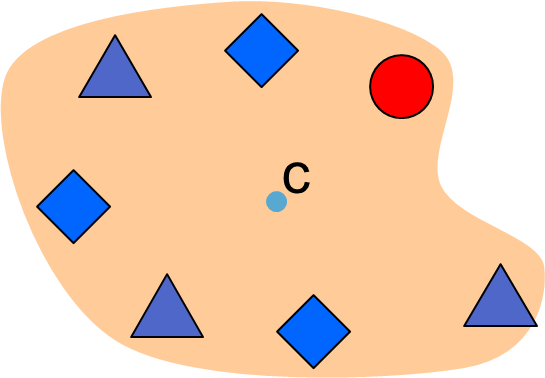

C is the centroid of the temmplate. The other marked points are the features. We also store the displacement vector from the centroid to the feature point.

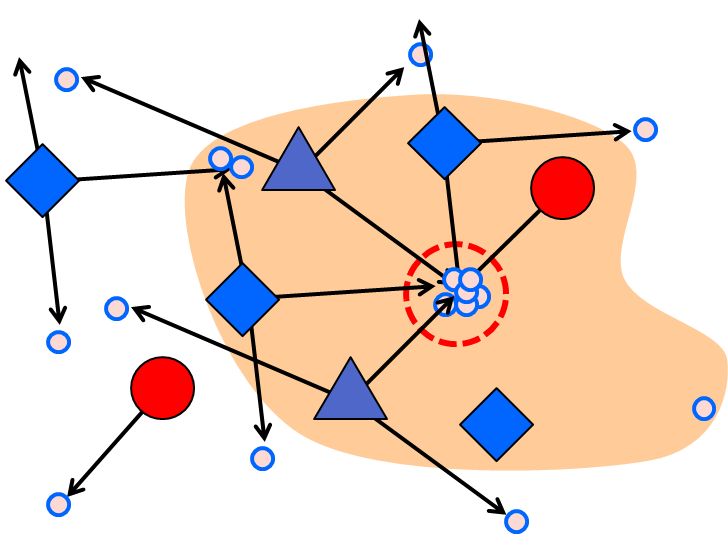

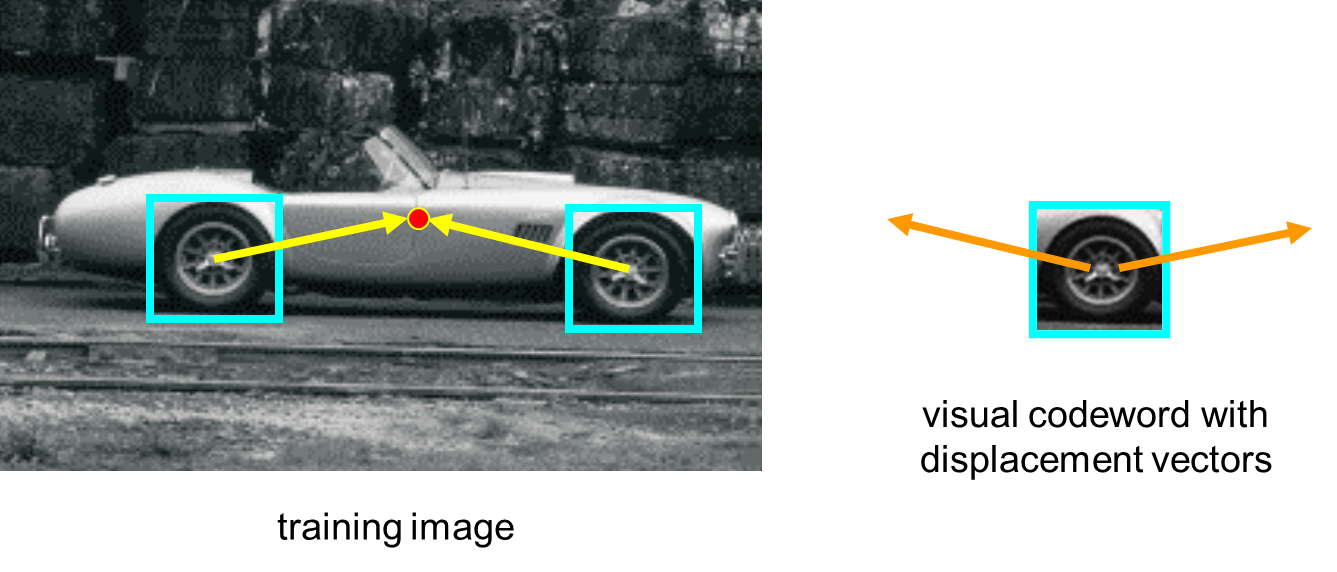

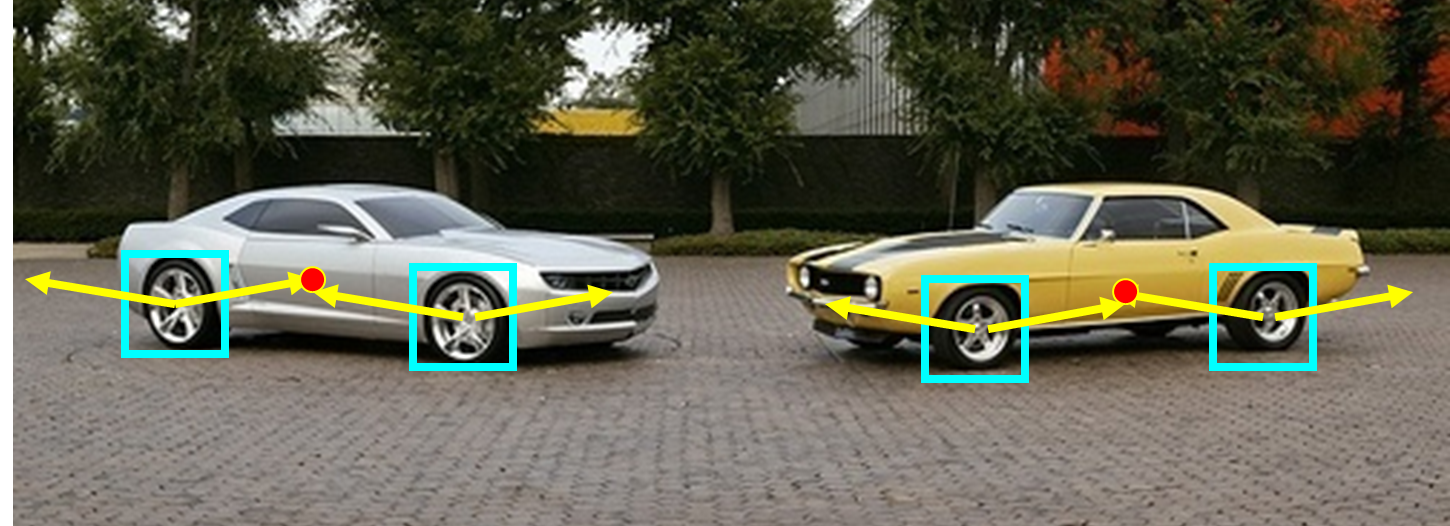

In [3]:
try:
    im = cv.imread('images/pic1.png', cv.IMREAD_REDUCED_GRAYSCALE_2)
    templ  = cv.imread('images/templ.png', cv.IMREAD_REDUCED_GRAYSCALE_2)

    # Canny edge detection
    im_edges = cv.Canny(im, 50, 250)
    templ_edges = cv.Canny(templ, 50, 250)

    alg = cv.createGeneralizedHoughGuil()
    alg.setTemplate(templ_edges)

    # Canny thresholds not reuired as 
    # alg.setCannyLowThresh(50)
    # alg.setCannyHighThresh(250)

    # Votes thresholds (to be carefully selected)
    alg.setAngleThresh(100000)
    alg.setScaleThresh(40000)
    alg.setPosThresh(1000)

    # alg.setAngleThresh(400000)
    # alg.setScaleThresh(10000)
    # alg.setPosThresh(100)

    alg.setAngleStep(1)
    alg.setScaleStep(0.1)
    alg.setMinScale(0.9)       
    alg.setMaxScale(1.1)

    positions, votes = alg.detect(im_edges) # Actual detection

    out = cv.cvtColor(im, cv.COLOR_BAYER_BG2BGR)
    for x, y, scale, orientation in positions[0]:
        halfHeight = templ.shape[0] / 2. * scale
        halfWidth = templ.shape[1]/ 2. * scale
        p1 = (int(x - halfWidth), int(y - halfHeight))
        p2 = (int(x + halfWidth), int(y + halfHeight))
        print("x = {}, y = {}, scale = {}, orientation = {}, p1 = {}, p2 = {}".format(x, y, scale, orientation, p1, p2))
        cv.rectangle(out, p1, p2, (0,0,255))

    cv.namedWindow('Image')
    cv.imshow('Image', templ)
    cv.waitKey(0)
    cv.imshow('Image', im)
    cv.waitKey(0)
    cv.imshow('Image', out)
    cv.waitKey(0)
    cv.destroyAllWindows()

except:
    print("Error loading image")
    cv.destroyAllWindows()

Error loading image


What if we add scale and rotation?

Then the number of parameters increases. It is computationally possible but very expensive.